# Grid Search Results

In [247]:
from utils.dataloader import Assistments
from utils.transforms import *
from utils.features import *
from cluster_methods import *

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

sns.set_style('darkgrid')

Read the grid search CSV as a dataframe (and remove one of the columns since I spelled it wrong).

In [191]:
GRID_SEARCH_FILE = 'GridSearch_22-01_11:58:32.csv'
results = pd.read_csv(GRID_SEARCH_FILE, header=0)

# Drop V-measure (called V_measure) and index
results = results.drop(columns=['V-measure', 'Unnamed: 0'])

## Plot average metric values across cluster methods

In [192]:
metrics=['silhouette', 'homogeneity', 'completeness', 'ARI', 'V_measure']

# Long form DF
metrics_long = pd.melt(results, id_vars=['cluster_method'], value_vars=metrics, var_name='metric', value_name='metric_value')
metrics_long.head()

cluster_method      metric  metric_value
0         KMeans  silhouette      0.357944
1         KMeans  silhouette      0.242558
2         KMeans  silhouette      0.261328
3         KMeans  silhouette      0.261960
4         KMeans  silhouette      0.255904

<AxesSubplot:xlabel='cluster_method', ylabel='metric_value'>

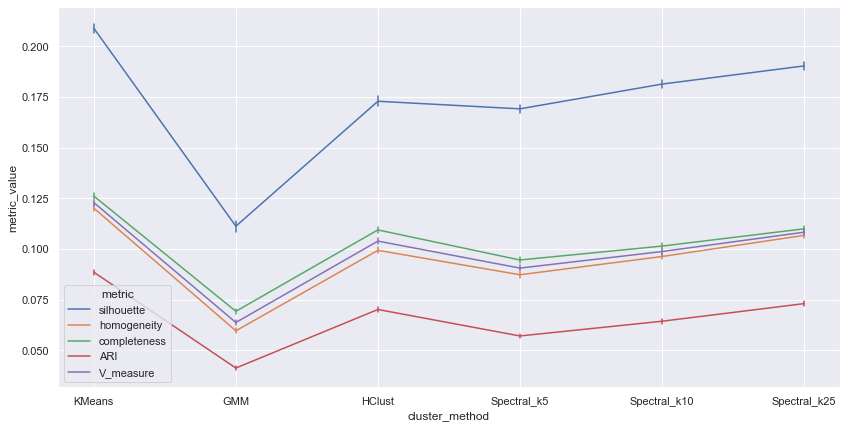

In [193]:
# Start figure
sns.set(rc={"figure.figsize":(14, 7)})
sns.lineplot(data=metrics_long, x='cluster_method', y='metric_value', hue='metric', err_style='bars')

These all look fairly similar... let's get the correlation between metric values.

In [43]:
corrs = results[metrics].corr(method='pearson')
sns.heatmap(corrs, annot=True)

<AxesSubplot:>

Expectedly, external metrics are all fairly similar... Let's take a look at silhouette score itself to see if there's an optimal k?

## Plot average silhouette score across values of $k$


In [44]:
sns.set(rc={"figure.figsize":(14, 7)})
sns.lineplot(data=results, x='k', y='silhouette', err_style='bars')

<AxesSubplot:xlabel='k', ylabel='silhouette'>

It seems like its almost uniformly descending as $k$ increases. It's likely that the best cluster separation occurs at $k = 2$

## Feature set analysis
### Plot average external metric values given feature presence for each feature
Is there a best feature? Is there anything contrary to the correlation?

In [47]:
feature_cols = [col for col in results.columns if col.startswith('feature') and col != 'feature_set_id']

In [112]:
ext_metrics = ['ARI', 'homogeneity', 'completeness', 'V_measure']
feature_scores = []

for feature in feature_cols:
    df_filtered = results[results[feature] == 1]
    
    row = { 'feature': feature.replace('feature_', '') }
    for m in ext_metrics:
        row['avg_' + m] = df_filtered[m].mean()
    
    feature_scores.append(row)
    
feature_scores = pd.DataFrame(feature_scores, columns=['feature'] + ['avg_' + m for m in ext_metrics])

<AxesSubplot:title={'center':'Average Adjusted Rand Index for each feature'}, xlabel='avg_ARI', ylabel='feature'>

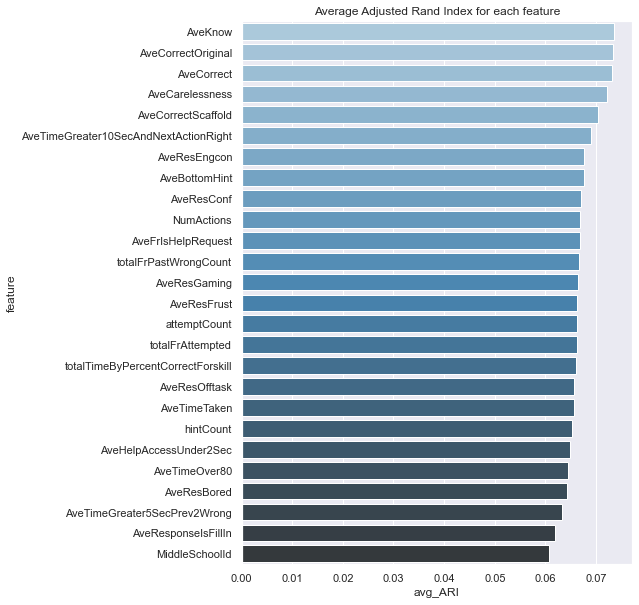

In [113]:
sns.set(rc={"figure.figsize":(7, 10)})
plt.title('Average Adjusted Rand Index for each feature')
sns.barplot(data=feature_scores.sort_values(ascending=False, by='avg_ARI'), y='feature', x='avg_ARI', palette='Blues_d')

Get the correlation between average ARI and spearman correlation?

In [136]:
feature_corrs = pd.read_csv('correlations.csv', header=0)
feature_scores_with_corr = feature_scores.merge(feature_corrs, on='feature').set_index('feature')
feature_scores_with_corr.corrwith(feature_scores_with_corr['spearman'])

avg_ARI             0.647631
avg_homogeneity     0.634941
avg_completeness    0.633532
avg_V_measure       0.634759
spearman            1.000000
dtype: float64

It's not perfect, let's see any ranking changes?

In [141]:
feature_scores_with_corr['Spearman_rank'] = feature_scores_with_corr['spearman'].rank(ascending=False)
feature_scores_with_corr['ARI_rank'] = feature_scores_with_corr['avg_ARI'].rank(ascending=False)
feature_scores_with_corr['Ranking_change'] = feature_scores_with_corr['Spearman_rank'] - feature_scores_with_corr['ARI_rank']
feature_scores_with_corr[['ARI_rank', 'Spearman_rank', 'Ranking_change']].sort_values(by='ARI_rank')

ARI_rank  Spearman_rank  Ranking_change
feature                                                                       
AveKnow                                     1.0            2.0             1.0
AveCorrectOriginal                          2.0            3.0             1.0
AveCorrect                                  3.0            1.0            -2.0
AveCarelessness                             4.0            5.0             1.0
AveCorrectScaffold                          5.0            6.0             1.0
AveTimeGreater10SecAndNextActionRight       6.0            4.0            -2.0
AveResEngcon                                7.0           12.0             5.0
AveBottomHint                               8.0           26.0            18.0
AveResConf                                  9.0           16.0             7.0
NumActions                                 10.0           19.0             9.0
AveFrIsHelpRequest                         11.0            7.0            -4.0
totalFrPastWrongCount                      12.0           22.0            10.0
AveResGaming                               13.0           25.0            12.0
AveResFrust                                14.0           20.0             6.0
attemptCount                               15.0           21.0             6.0
totalFrAttempted                           16.0           14.0            -2.0
totalTimeByPercentCorrectForskill          17.0            8.0            -9.0
AveResOfftask                              18.0           11.0            -7.0
AveTimeTaken                               19.0           10.0            -9.0
hintCount                                  20.0           23.0             3.0
AveHelpAccessUnder2Sec                     21.0           24.0             3.0
AveTimeOver80                              22.0            9.0           -13.0
AveResBored                                23.0           13.0           -10.0
AveTimeGreater5SecPrev2Wrong               24.0           15.0            -9.0
AveResponseIsFillIn                        25.0           17.0            -8.0
MiddleSchoolId                             26.0           18.0            -8.0

Do any features work particularly well with other features?

In [176]:
import itertools

ext_metrics = ['ARI', 'homogeneity', 'completeness', 'V_measure']
feature_pairs = []

# Iterate over all non reflexive combinations
for f1, f2 in itertools.combinations(feature_cols, r=2):
    df_both = results[(results[f1] == 1) & (results[f2] == 1)] 
    df_either = results[(results[f1] == 1) | (results[f2] == 1)] 
    row = { 'feature_1': f1.replace('feature_', ''), 'feature_2': f2.replace('feature_', '') }
    
    for m in ext_metrics:
        avg_val = df_both[m].mean()
        row['avg_' + m] = avg_val
        
        # Change in avg metric score with BOTH f1 and f2 compared to EITHER f1 or f2
        row['avg_' + m + '_change'] = avg_val - df_either[m].mean()
            
    feature_pairs.append(row)
    
feature_pairs = pd.DataFrame(feature_pairs)

In [183]:
# Show pairs as a grid
plt.title('Change in average Adjusted Rand Index value for intersection of feature sets versus union')
sns.set(rc={"figure.figsize":(12, 10)})
sns.heatmap(feature_pairs.pivot('feature_1', 'feature_2', 'avg_ARI_change'))

<AxesSubplot:title={'center':'Change in average Adjusted Rand Index value for intersection of feature sets versus union'}, xlabel='feature_2', ylabel='feature_1'>

### Feature set size analysis
Generally, are things better with more or less features?

In [198]:
feature_set_sizes = results.copy()
feature_set_sizes['f_set_size'] = feature_set_sizes[feature_cols].sum(axis=1)

sns.set(rc={"figure.figsize":(14, 7)})
sns.lineplot(data=feature_set_sizes, x='f_set_size', y='ARI')

<AxesSubplot:xlabel='f_set_size', ylabel='ARI'>

So it seems like the best performing feature sets are at sizes 5 and 26.

## Get the best performing experiments!

In [314]:
best_methods = {}

top_k = 3
for m in metrics:
    best3 = results.sort_values(by=m, ascending=False).head(3)
    
    for i in range(top_k):  
        method = best3.iloc[i]
        method_id = best3.index[i]
        
        if method_id in best_methods:
            best_methods[method_id][f'metrics_top{top_k}'].append(m)
        else:
            best_methods[method_id] = { f'metrics_top{top_k}': [m] }
            
best_methods = [ { '': method_id, **info } for method_id, info in best_methods.items() ]
best_methods = pd.DataFrame(best_methods).set_index('')
best_methods = best_methods.join(feature_set_sizes)
best_methods

metrics_top3 cluster_method  \
                                                                    
17112                                 [silhouette]         HClust   
3174                                  [silhouette]            GMM   
3678                                  [silhouette]            GMM   
16956  [homogeneity, completeness, ARI, V_measure]         KMeans   
16968                [homogeneity, ARI, V_measure]         HClust   
16986                [homogeneity, ARI, V_measure]   Spectral_k25   
8245                                [completeness]         KMeans   
16975                               [completeness]    Spectral_k5   

       feature_set_id  feature_AveKnow  feature_AveCarelessness  \
                                                                  
17112             475                0                        0   
3174               88                0                        0   
3678              102                0                        0   
16956             471                0                        0   
16968             471                0                        0   
16986             471                0                        0   
8245              229                1                        1   
16975             471                0                        0   

       feature_AveCorrect  feature_NumActions  feature_AveResBored  \
                                                                     
17112                   0                   0                    0   
3174                    0                   0                    0   
3678                    0                   0                    1   
16956                   1                   0                    0   
16968                   1                   0                    0   
16986                   1                   0                    0   
8245                    1                   0                    0   
16975                   1                   0                    0   

       feature_AveResEngcon  feature_AveResConf  ...  feature_attemptCount  \
                                                 ...                         
17112                     0                   0  ...                     0   
3174                      1                   0  ...                     1   
3678                      0                   0  ...                     1   
16956                     0                   0  ...                     0   
16968                     0                   0  ...                     0   
16986                     0                   0  ...                     0   
8245                      0                   0  ...                     0   
16975                     0                   0  ...                     0   

       feature_totalFrPastWrongCount  feature_totalFrAttempted  k  silhouette  \
                                                                                
17112                              0                         0  2    0.896237   
3174                               1                         0  2    0.873598   
3678                               0                         1  2    0.855888   
16956                              0                         0  2    0.421861   
16968                              0                         0  2    0.359350   
16986                              0                         0  2    0.401189   
8245                               0                         0  3    0.392528   
16975                              0                         0  3    0.387277   

       homogeneity  completeness       ARI  V_measure  f_set_size  
                                                                   
17112     0.001340      0.084598 -0.000315   0.002637           5  
3174      0.001340      0.084598 -0.000315   0.002637           7  
3678      0.001340      0.084598 -0.000315   0.002637           9  
16956     0.279367      0.293166  0.349366 

## Learn more about the best methods by re-doing them and visualizing

In [236]:
# Load dataset
PATH = 'assistments_2017.csv'

assistments = Assistments(PATH)

# Apply data transforms/features
steps = [
    StudentFeatures(),
    AggStudentFeatures(),
    AvgCorrectFeatures(),
    LastActionStudentFeatures(),
]

assistments.apply(steps)
assistments.hide_feature('InferredGender')
assistments.apply([Standardize(),])
assistments.hide_feature('MCAS')

/Users/tzhou/Git/eduai-project/utils/dataloader.py:62: DtypeWarning: Columns (76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  self.raw_data = pd.read_csv(path, header=0)


Total number of actions: 942816
Total unique students: 1709
Total unique students after MCAS clean: 1376
Applying 4 steps:
Step 1/4: <class 'utils.features.StudentFeatures'>
Step 2/4: <class 'utils.features.AggStudentFeatures'>
Step 3/4: <class 'utils.features.AvgCorrectFeatures'>
Step 4/4: <class 'utils.features.LastActionStudentFeatures'>
Applying 1 steps:
Step 1/1: <class 'utils.transforms.Standardize'>


In [308]:
def plot_clusters(data, cluster_labels, MCAS):
    """
    Plot the clusters with hue = cluster labels.
    Plot clusterwise distributions against 
    """    
    # Check for dim reduction
    if data.shape[1] > 2:
        # dimension reduce to 2 using PCA
        pca = PCATransform(n_components = 2, random_state = 33)
        data = pca.apply(data)
      
    # Start figure
    fig, ax = plt.subplots(3, 1, figsize=(10, 20), gridspec_kw={'height_ratios': [2, 1, 1]})
                
    # Plot 
    sns.set(rc={"figure.figsize":(10, 10)})

    sns.scatterplot(data = data, x = "PC1", y = "PC2", hue = cluster_labels, palette='deep', ax = ax[0])
    
    # add the average correctness column back to the students data frame
    data_mcas = data.join(MCAS)

    # add cluster labels to the students data frame
    data_mcas_labeled = pd.concat([data_mcas, pd.DataFrame(cluster_labels, columns=['cluster_labels'], 
                                                         index = MCAS.index)], axis = 1)

    # plot a histogram of the students based on mean problem correctness 
    sns.histplot(data = data_mcas_labeled, x = 'MCAS', hue = 'cluster_labels', palette='deep', ax = ax[1])
    sns.kdeplot(data = data_mcas_labeled, x = 'MCAS', hue = 'cluster_labels', palette='deep', ax = ax[2])
    
    plt.show()

In [309]:
def get_features_from_method(method_row):
    features = []
    
    for f in feature_cols:
        if method_row[f]:
            features.append(f.replace('feature_',''))
            
    return features

### Experiment 16956
This one looks like it performed in the top 3 w.r.t. _all_ external cluster metrics.

In [343]:
def eval_method(method_id, cluster_method):
    m_row = feature_set_sizes.loc[method_id]
    feature_set = get_features_from_method(m_row)
    
    print(feature_set)
    print(m_row['k'], m_row['cluster_method'])
    
    subsetted_data = assistments.data[feature_set]
    
    labels = cluster_method.cluster(subsetted_data, n_clusters=m_row['k'])
    plot_clusters(subsetted_data, labels, assistments.hidden['MCAS'])
    return labels

In [344]:
m16956_labels = eval_method(16956, KMeansClusterMethod())

['AveCorrect', 'AveFrIsHelpRequest', 'AveCorrectOriginal']
2 KMeans
Variance explained:  [0.66208781 0.31481879]


### Experiment 8245
This one has 6 features

['AveKnow', 'AveCarelessness', 'AveCorrect', 'AveResOfftask', 'totalTimeByPercentCorrectForskill', 'AveFrIsHelpRequest']
3 KMeans
Variance explained:  [0.48708282 0.19828696]


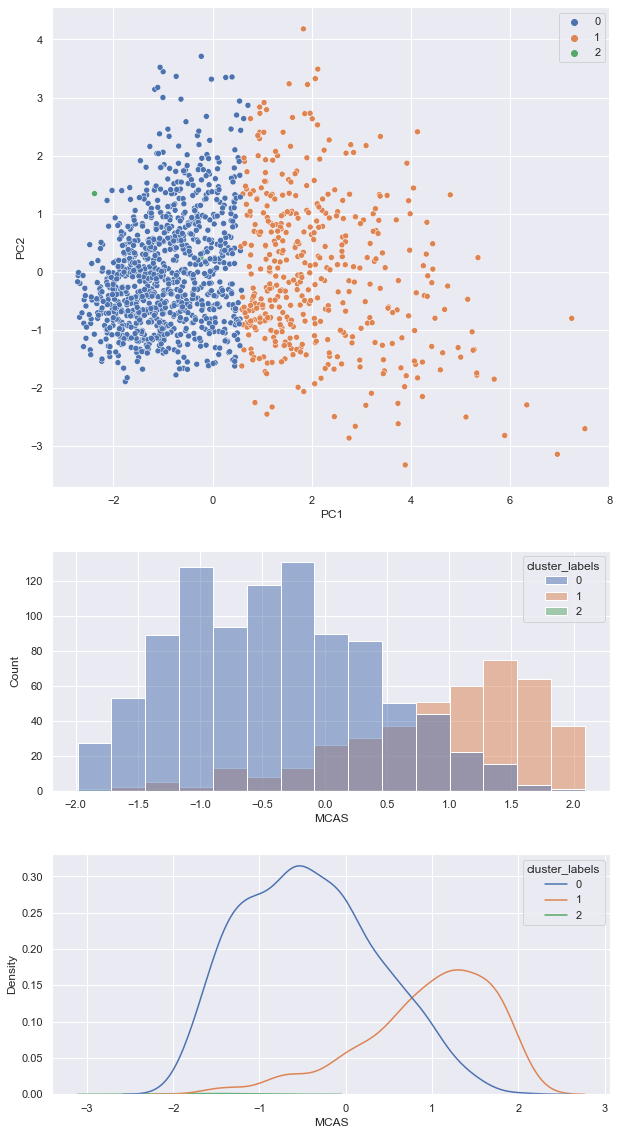

In [345]:
m8245_labels = eval_method(8245, KMeansClusterMethod())

### Experiment 17112
High silhouette score, and hierarchical clust?

In [346]:
m17112_labels = eval_method(17112, HierarchicalClusterMethod())

['AveResFrust', 'totalTimeByPercentCorrectForskill', 'MiddleSchoolId', 'AveBottomHint', 'AveCorrectOriginal']
2 HClust
Variance explained:  [0.32368983 0.25258938]


### Experiments 5221 (uses all features)

In [347]:
m5221_labels = eval_method(5221, KMeansClusterMethod())

['AveKnow', 'AveCarelessness', 'AveCorrect', 'NumActions', 'AveResBored', 'AveResEngcon', 'AveResConf', 'AveResFrust', 'AveResOfftask', 'AveResGaming', 'totalTimeByPercentCorrectForskill', 'MiddleSchoolId', 'AveTimeTaken', 'AveBottomHint', 'AveFrIsHelpRequest', 'AveTimeGreater5SecPrev2Wrong', 'AveResponseIsFillIn', 'AveHelpAccessUnder2Sec', 'AveTimeGreater10SecAndNextActionRight', 'AveTimeOver80', 'AveCorrectOriginal', 'AveCorrectScaffold', 'hintCount', 'attemptCount', 'totalFrPastWrongCount', 'totalFrAttempted']
3 KMeans
Variance explained:  [0.38356464 0.17333715]


## Analysing the clusters from 5221 and 16956
i.e., the clusters with the highest ext scores, and highest scores with all features.

In [392]:
assistments.hidden['InferredGender'].fillna('Unknown', inplace=True)

### 16956: Does the three feature clustering have anything else interesting behind it?

In [403]:
assistments_labeled['m16956'] = m16956_labels

In [404]:
assistments_labeled.corrwith(assistments_labeled['m16956'], method='spearman').sort_values(ascending=False)

m16956                                   1.000000
AveCorrect                               0.822748
AveTimeGreater10SecAndNextActionRight    0.775350
AveCorrectOriginal                       0.762286
AveKnow                                  0.747409
AveCarelessness                          0.647486
AveTimeOver80                            0.454598
AveTimeTaken                             0.446666
AveFrIsHelpRequest                       0.387701
AveResOfftask                            0.347664
AveCorrectScaffold                       0.346398
totalTimeByPercentCorrectForskill        0.271724
AveResBored                              0.246730
AveTimeGreater5SecPrev2Wrong             0.164518
AveResEngcon                             0.052641
AveResConf                               0.022554
MiddleSchoolId                          -0.033702
totalFrAttempted                        -0.092060
AveResponseIsFillIn                     -0.118771
AveResFrust                             -0.232625


Variance explained:  [0.38356464 0.17333715]


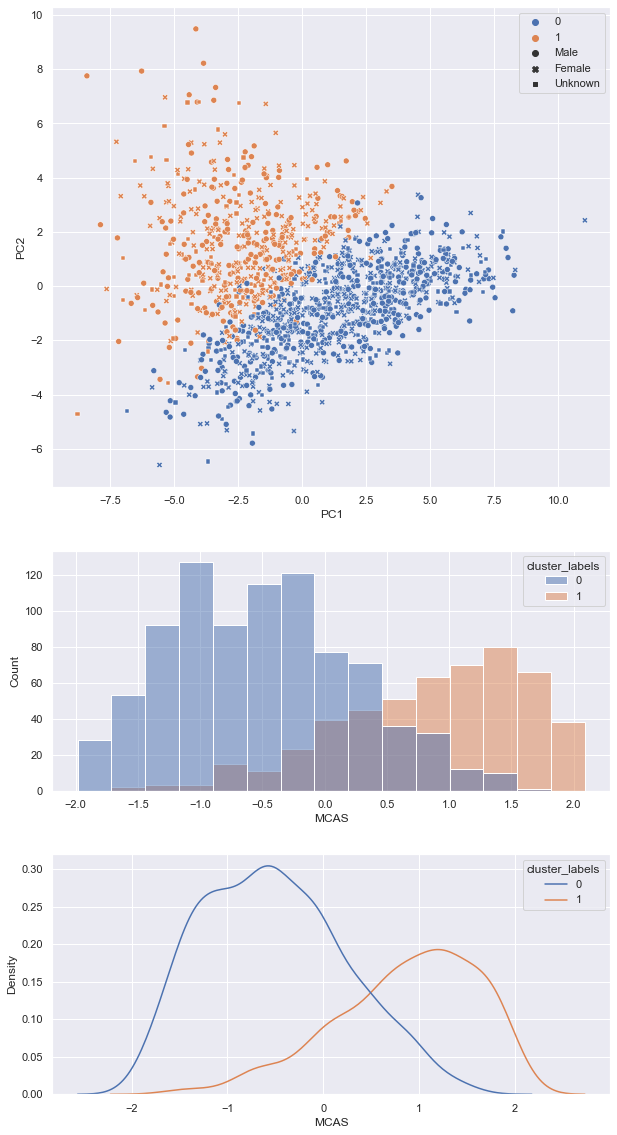

In [424]:
def plot_clusters_with_gender(data, cluster_labels, gender, MCAS):
    # Check for dim reduction
    if data.shape[1] > 2:
        # dimension reduce to 2 using PCA
        pca = PCATransform(n_components = 2, random_state = 33)
        data = pca.apply(data)
      
    # Start figure
    fig, ax = plt.subplots(3, 1, figsize=(10, 20), gridspec_kw={'height_ratios': [2, 1, 1]})
                
    # Plot 
    sns.set(rc={"figure.figsize":(10, 10)})

    sns.scatterplot(data = data, x = "PC1", y = "PC2", hue = cluster_labels, style = gender, palette='deep', ax = ax[0])
    
    # add the average correctness column back to the students data frame
    data_mcas = data.join(MCAS)

    # add cluster labels to the students data frame
    data_mcas_labeled = pd.concat([data_mcas, pd.DataFrame(cluster_labels, columns=['cluster_labels'], index = MCAS.index)], axis = 1)

    # plot a histogram of the students based on mean problem correctness 
    sns.histplot(data = data_mcas_labeled, x = 'MCAS', hue = 'cluster_labels', palette='deep', ax = ax[1])
    sns.kdeplot(data = data_mcas_labeled, x = 'MCAS', hue = 'cluster_labels', palette='deep', ax = ax[2])
    
    plt.show()
    
plot_clusters_with_gender(assistments.data, m16956_labels, assistments.hidden['InferredGender'].values.flatten(), assistments.hidden['MCAS'])

### 5221: What else can we learn: i.e., what's the third cluster?

In [433]:
assistments_labeled_5221 = assistments.data.copy()
assistments_labeled_5221['cluster'] = m5221_labels

Variance explained:  [0.38356464 0.17333715]


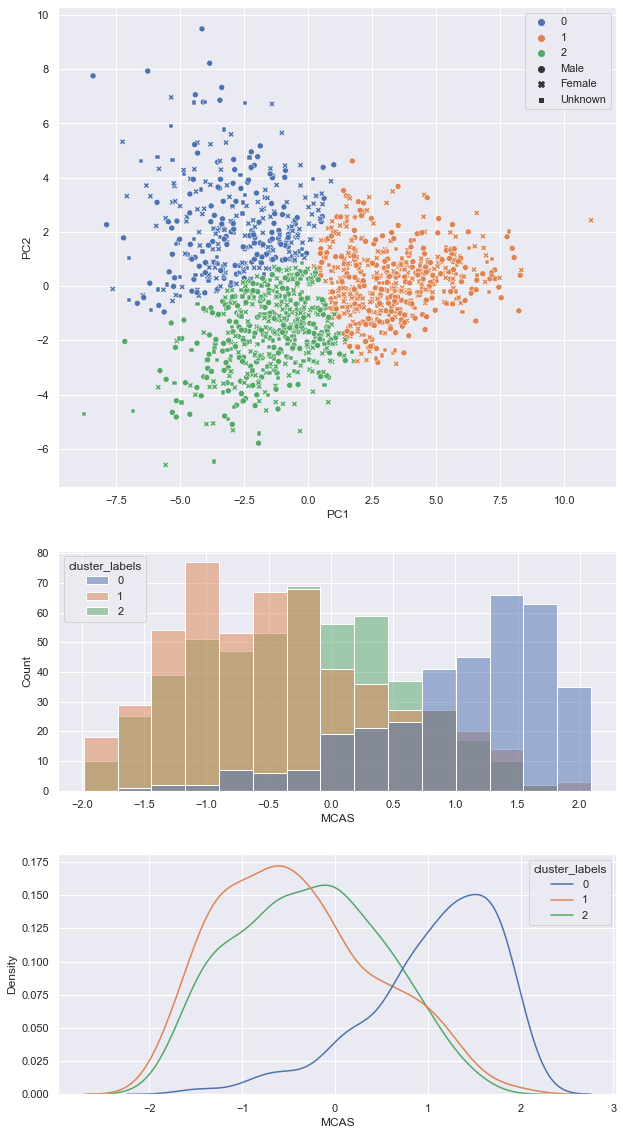

In [434]:
plot_clusters_with_gender(assistments.data, m5221_labels, assistments.hidden['InferredGender'].values.flatten(), assistments.hidden['MCAS'])

Perform t-test to check differences between cluster 1 and 2. Are there any major diffs?

In [451]:
from scipy.stats import ttest_ind

cluster1 = assistments_labeled_5221[assistments_labeled_5221['cluster'] == 1]
cluster2 = assistments_labeled_5221[assistments_labeled_5221['cluster'] == 2]

t_res = []

for col in cluster1.columns:
    if col == 'cluster':
        continue
        
    # t-test difference
    res = ttest_ind(cluster1[col], cluster2[col], equal_var=False)
    
    if res.pvalue < (0.05 / (len(cluster1.columns) - 1)):
        test = { 'col': col, 't': res.statistic, 'p': res.pvalue }
        t_res.append(test)
        
t_res = pd.DataFrame(t_res)
t_res['t_ab'] = t_res['t'].abs()

In [455]:
t_res.sort_values(by='t_ab', ascending=False)[:10]

col          t              p       t_ab
2                             AveResBored -42.370786  7.506287e-221  42.370786
13                 AveHelpAccessUnder2Sec  34.657597  4.249914e-159  34.657597
7                            AveResGaming  33.548502  4.532372e-152  33.548502
1                              NumActions  31.006655  2.871534e-134  31.006655
6                           AveResOfftask -30.366768  8.140040e-129  30.366768
8                            AveTimeTaken -29.917671  3.332147e-122  29.917671
14  AveTimeGreater10SecAndNextActionRight -29.706910  5.388061e-139  29.706910
15                          AveTimeOver80 -29.264884  4.053520e-120  29.264884
20                       totalFrAttempted  27.955199  1.712091e-119  27.955199
11           AveTimeGreater5SecPrev2Wrong -25.994439  1.948958e-101  25.994439

Cluster 1 and cluster 2 are both 'lower' MCAS, with cluster 1 having a slightly lower MCAS. But it seems like there are two distinct groups of students here!

Cluster 1 is much more likely to:
- Get bored
- Be offtask
- Take more time during questions

Cluster 2 is much more likely to:
- Ask for help
- Game the system
- As a result, have a lot more actions and attempt more problems